In [ ]:

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression



In [6]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

# preserva ids
test_ids = test["id"].copy()

# separa target e dropa ids
y = train["labels"].astype(int)
train_nolabel = train.drop(columns=["labels"])
if "id" in train_nolabel.columns:
    train_nolabel = train_nolabel.drop(columns=["id"])
test_nolabel = test.drop(columns=["id"])

In [7]:

def _safe_div(num, den):
    # evita inf/NaN em divisões
    num = num.astype("float64")
    den = den.astype("float64")
    return np.divide(num, den, out=np.zeros_like(num, dtype="float64"), where=den!=0)

def build_fe_stats(df):
    # estatísticas calculadas só no train (para flags que dependem de quantis/medianas)
    return {
        "relationships_q75": df["relationships"].quantile(0.75),
        "funding_total_median": df["funding_total_usd"].median(),
    }

def add_features(df, stats):
    X = df.copy()

    # razões
    X["funding_per_round"]           = _safe_div(X["funding_total_usd"], (X["funding_rounds"] + 1))
    X["funding_per_relationship"]    = _safe_div(X["funding_total_usd"], (X["relationships"] + 1))
    X["relationships_per_round"]     = _safe_div(X["relationships"], (X["funding_rounds"] + 1))
    X["milestones_per_relationship"] = _safe_div(X["milestones"], (X["relationships"] + 1))
    X["avg_funding_per_participant"] = _safe_div(X["funding_total_usd"], ((X["avg_participants"] * X["funding_rounds"]) + 1))

    # logs
    X["log_funding"]       = np.log1p(X["funding_total_usd"])
    X["log_relationships"] = np.log1p(X["relationships"])
    X["log_rounds"]        = np.log1p(X["funding_rounds"])

    # dinâmica temporal
    X["funding_velocity"]     = _safe_div(X["funding_total_usd"], (X["age_last_funding_year"] + 1))
    X["milestone_velocity"]   = _safe_div(X["milestones"], (X["age_last_milestone_year"] + 1))
    X["funding_acceleration"] = (X["age_last_funding_year"] - X["age_first_funding_year"] + 0.01)
    X["time_to_first_funding"]= X["age_first_funding_year"]

    # interações
    X["funding_x_relationships"] = X["funding_total_usd"] * X["relationships"]
    X["rounds_x_participants"]   = X["funding_rounds"] * X["avg_participants"]
    X["vc_angel_combo"]          = X["has_VC"] * X["has_angel"]

    # flags por estágio
    X["has_late_stage"]      = ((X["has_roundC"] == 1) | (X["has_roundD"] == 1)).astype(int)
    X["has_series_funding"]  = ((X["has_roundB"] == 1) | (X["has_roundC"] == 1) | (X["has_roundD"] == 1)).astype(int)
    X["has_early_funding"]   = ((X["has_angel"] == 1) | (X["has_roundA"] == 1)).astype(int)
    X["funding_progression"] = (X["has_roundA"] + X["has_roundB"] + X["has_roundC"] + X["has_roundD"]).astype(int)

    # flags com estatísticas do train
    X["fast_to_funding"]         = (X["age_first_funding_year"] < 1).astype(int)
    X["high_relationship_count"] = (X["relationships"] > stats["relationships_q75"]).astype(int)
    X["well_funded"]             = (X["funding_total_usd"] > stats["funding_total_median"]).astype(int)

    # higiene
    X = X.replace([np.inf, -np.inf], 0)

    # preencher idades faltantes como -1 (sinalização)
    age_cols = [
        "age_first_funding_year", "age_last_funding_year",
        "age_first_milestone_year", "age_last_milestone_year"
    ]
    for c in age_cols:
        if c in X.columns:
            X[c] = X[c].fillna(-1)

    # funding_total_usd faltante -> mediana (do train)
    if "funding_total_usd" in X.columns:
        X["funding_total_usd"] = X["funding_total_usd"].fillna(stats["funding_total_median"])

    return X

In [8]:

fe_stats = build_fe_stats(train_nolabel)
train_fe = add_features(train_nolabel, fe_stats)
test_fe  = add_features(test_nolabel,  fe_stats)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    train_fe, y, test_size=0.20, random_state=42, stratify=y)

In [10]:
categorical_cols = [c for c in train_fe.columns if c == "category_code"]
numeric_cols     = [c for c in train_fe.columns if c not in categorical_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", KNNImputer(n_neighbors=5, weights="distance")),
        ]), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_cols)
    ],
    remainder="drop"  # mantém só o que foi especificado
)

In [11]:
base_models = [
    ("rf", RandomForestClassifier(
        n_estimators=400, max_depth=12,
        min_samples_split=10, min_samples_leaf=5,
        max_features="sqrt", class_weight="balanced",
        random_state=42, n_jobs=-1
    )),
    ("et", ExtraTreesClassifier(
        n_estimators=400, max_depth=12,
        min_samples_split=10, min_samples_leaf=5,
        max_features="sqrt", class_weight="balanced",
        random_state=43, n_jobs=-1
    )),
    ("gb", GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05,
        max_depth=5, min_samples_split=15,
        min_samples_leaf=8, subsample=0.8,
        random_state=44
    )),
    ("lr", LogisticRegression(
        C=0.5, class_weight="balanced",
        max_iter=1000, random_state=45
    )),
]

meta_learner = LogisticRegression(
    C=1.0, class_weight="balanced",
    max_iter=1000, random_state=46
)

stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,  # crucial pra evitar overfitting no stack
    stack_method="predict_proba",
    n_jobs=-1
)


In [12]:
clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", stacking)
])

Val Accuracy: 0.8154

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74        46
           1       0.86      0.86      0.86        84

    accuracy                           0.82       130
   macro avg       0.80      0.80      0.80       130
weighted avg       0.82      0.82      0.82       130



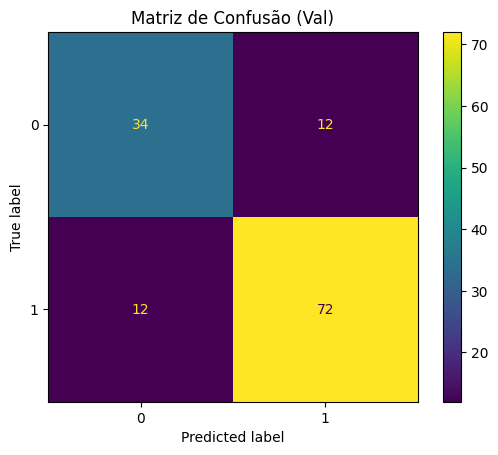

In [13]:
clf.fit(X_train, y_train)
y_val_pred = clf.predict(X_val)

acc = accuracy_score(y_val, y_val_pred)
print(f"Val Accuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.title("Matriz de Confusão (Val)")
plt.show()

In [14]:
clf.fit(train_fe, y)
pred_test = clf.predict(test_fe)

submission = pd.DataFrame({"id": test_ids, "labels": pred_test.astype(int)})
submission.to_csv("submission.csv", index=False)
print("submission.csv salvo com", len(submission), "linhas")

submission.csv salvo com 277 linhas


/home/guilherme/.local/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
